# Problem Description

We want to predict a category of product based on its title, description and other parameters.

## Data

**categories_tree.csv** - file with a category tree of marketplace. Each category has an id, title, and parent_id, which can be used to restore the full path of the category.

**train.parquet** - file with marketplace products.
Each product has:

* *id*
* *title*
* *name_value_characteristics* - name:value of a product characteristic. Can be several for each product and for each characteristic.
* *rating* - average product rating
* *feedback_quantity* - number of product reviews
* *category_id* - product category (target)

**test.parquet** - file, which is identical to train.parquet, but without a real category_id, which is exactly what we have to predict.

## Metric

Predicting the leaf category of a product may seem like a trivial task, but the path to the leaf category is important to us. For incorrectly predicted leaf categories, we want to increase score if the parent categories were predicted correctly at different levels.

We are going to use a modified F1-metric weighted by the sample size of the class (only leaf categories are taken into account when calculating):
$$ hP = \frac{\sum_i |\hat{P_i} \cap \hat{T_i}|}{\sum_i |\hat{P_i}|} $$
$$ hR = \frac{\sum_i |\hat{P_i} \cap \hat{T_i}|}{\sum_i |\hat{T_i}|} $$
$$ hF = \frac{2 * hP * hR}{hP + hR} $$
* $P_i$ is a set consisting of predicted categories for each i_th sample and the corresponding ancestor categories
* $T_i$ is a set consisting of true categories for each i_th sample and the corresponding ancestor categories
* $hP$ - hierarchical precision
* $hR$ - hierarchical recall
* $hF$ - hierarchical F1-score

This metric was taken from the following paper:
https://www.cs.kent.ac.uk/people/staff/aaf/pub_papers.dir/DMKD-J-2010-Silla.pdf

# Prerequisites

In [ ]:
!pip install transformers
!pip install datasets

In [ ]:
!wget https://www.dropbox.com/s/0kcg8bd19384frb/categories_tree.csv?dl=0 -O categories_tree.csv
!wget https://www.dropbox.com/s/vmq48wfgoddhkeq/test.parquet?dl=0 -O test.parquet
!wget https://www.dropbox.com/s/1l4xihgg7ezsivk/train.parquet?dl=0 -O train.parquet

In [98]:
import pandas as pd
import numpy as np

from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel, DataCollatorWithPadding, \
                         AutoConfig, Trainer, TrainingArguments, AdamW, get_scheduler
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

SEED = 228
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

# Category Tree Processing

In [5]:
categories_tree = pd.read_csv('./categories_tree.csv')
categories_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370 entries, 0 to 3369
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3370 non-null   int64 
 1   title      3370 non-null   object
 2   parent_id  3370 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 79.1+ KB


Since further we're gonna predict final categories of tree, we're gonna need some utility function to be able to reconstruct the whole tree path to this category.

In [6]:
def get_path(category_id):
    path = []
    while category_id:
        path.append(int(categories_tree[categories_tree['id'] == category_id]['id']))
        category_id = int(categories_tree[categories_tree['id'] == category_id]['parent_id'])
    return path[::-1]

# Dataset Preprocessing

In [7]:
df_raw = pd.read_parquet('train.parquet')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283452 entries, 0 to 283451
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          283452 non-null  int64  
 1   title                       283452 non-null  object 
 2   short_description           133130 non-null  object 
 3   name_value_characteristics  50360 non-null   object 
 4   rating                      283452 non-null  float64
 5   feedback_quantity           283452 non-null  int64  
 6   category_id                 283452 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 15.1+ MB


Step 0: little analysis. Let's check target distribution.

In [97]:
df_raw['category_id'].value_counts()

11937    14967
13408     7153
13061     6434
13143     6145
13253     3390
         ...  
13756        2
13007        2
2598         2
11917        2
13787        2
Name: category_id, Length: 1231, dtype: int64

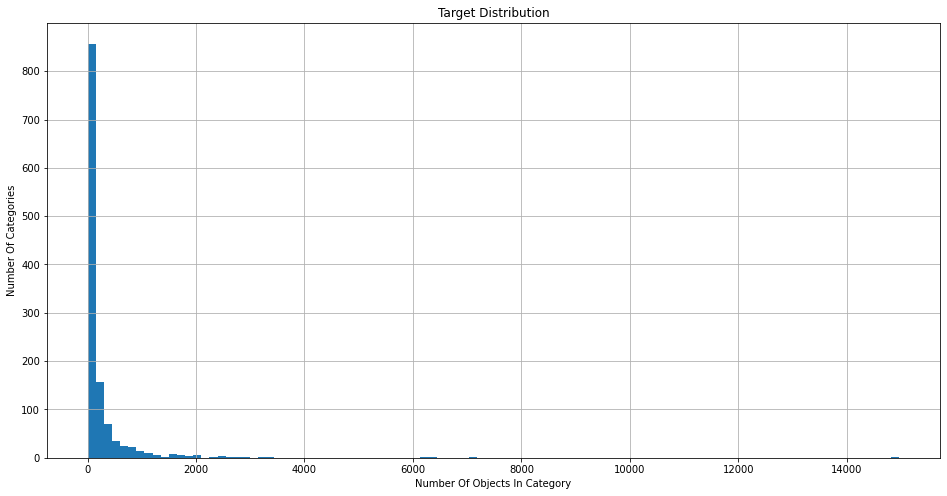

In [108]:
plt.hist(df_raw['category_id'].value_counts().values, bins=100)
plt.title('Target Distribution')
plt.xlabel('Number Of Objects In Category')
plt.ylabel('Number Of Categories')
plt.grid()
plt.show()

As we can see, data has significant imbalance of classes. Let's note this fact and move further.

First, let's join our text features into one.

In [8]:
df_raw.fillna(value = '', inplace = True)
df_raw['corpus'] = df_raw['title'] + '.' + df_raw['short_description'] # '.' so the nlp model could see the seperation of two parts
df_raw

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,category_id,corpus
0,1267423,Muhle Manikure Песочные колпачки для педикюра ...,Muhle Manikure Колпачок песочный шлифовальный ...,,0.000000,0,2693,Muhle Manikure Песочные колпачки для педикюра ...
1,128833,"Sony Xperia L1 Защитное стекло 2,5D",,,4.666667,9,13408,"Sony Xperia L1 Защитное стекло 2,5D."
2,569924,"Конверт для денег Прекрасная роза, 16,5 х 8 см","Конверт для денег «Прекрасная роза», 16,5 × 8 см",,5.000000,6,11790,"Конверт для денег Прекрасная роза, 16,5 х 8 см..."
3,1264824,Серьги,,,0.000000,0,14076,Серьги.
4,1339052,Наклейки на унитаз для туалета на крышку бачок...,"Водостойкая, интересная наклейка на унитаз раз...",,0.000000,0,12401,Наклейки на унитаз для туалета на крышку бачок...
...,...,...,...,...,...,...,...,...
283447,584544,Эфирное масло аромамасло 20мл,Аромамаркетинг – это мощный инструмент по созд...,Выберите аромат:Ваниль|Персик|Холл гостиницы|Н...,4.500000,6,2674,Эфирное масло аромамасло 20мл.Аромамаркетинг –...
283448,1229689,"Форма для выпечки печенья ""Орешки""","Орешки со сгущенкой, форма для приготовления.",,5.000000,1,13554,"Форма для выпечки печенья ""Орешки"".Орешки со с..."
283449,904913,Магнит символ Нового года-Тигренок/(по 3 шт в уп),,,5.000000,1,11617,Магнит символ Нового года-Тигренок/(по 3 шт в ...
283450,1413201,"Рифленный нож / слайсер для фигурной нарезки, ...","Такими ножами удобно резать фрукты, овощи, сыр...","Вид:19,5х6 см",0.000000,0,14030,"Рифленный нож / слайсер для фигурной нарезки, ..."


Let's make our life easier and assume that all necessary information is concentrated in text features. This assumption allows us to (at least, at a rough guess) drop all numerical features and give nlp model complete freedom of decision-making.

In [9]:
df = df_raw[['corpus', 'category_id']].rename(columns={'category_id': 'label'})
df

,corpus,label
0,Muhle Manikure Песочные колпачки для педикюра ...,2693
1,"Sony Xperia L1 Защитное стекло 2,5D.",13408
2,"Конверт для денег Прекрасная роза, 16,5 х 8 см...",11790
3,Серьги.,14076
4,Наклейки на унитаз для туалета на крышку бачок...,12401
...,...,...
283447,Эфирное масло аромамасло 20мл.Аромамаркетинг –...,2674
283448,"Форма для выпечки печенья ""Орешки"".Орешки со с...",13554
283449,Магнит символ Нового года-Тигренок/(по 3 шт в ...,11617
283450,"Рифленный нож / слайсер для фигурной нарезки, ...",14030


Getting closer to deep learning and encoding our class label.

In [10]:
dataset = Dataset.from_pandas(df)
dataset = dataset.class_encode_column('label')
dataset.features

Stringifying the column:   0%|          | 0/284 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/284 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/29 [00:00<?, ?ba/s]

{'corpus': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=1231, names=['11530', '11533', '11536', '11539', '11540', '11542', '11546', '11548', '11549', '11550', '11552', '11554', '11560', '11564', '11565', '11567', '11568', '11573', '11574', '11580', '11581', '11587', '11593', '11596', '11597', '11598', '11600', '11602', '11603', '11605', '11613', '11615', '11617', '11619', '11621', '11622', '11623', '11626', '11635', '11636', '11637', '11638', '11639', '11643', '11645', '11647', '11648', '11649', '11655', '11657', '11658', '11659', '11663', '11670', '11672', '11674', '11678', '11681', '11686', '11694', '11708', '11711', '11712', '11713', '11714', '11716', '11717', '11719', '11720', '11721', '11722', '11725', '11730', '11731', '11732', '11733', '11734', '11735', '11736', '11738', '11745', '11750', '11751', '11753', '11756', '11757', '11760', '11761', '11762', '11764', '11767', '11770', '11771', '11774', '11778', '11790', '11793', '11797', '11799', '11805', '11808', '1

Data needs to be splitted in a stratified fashion (especially due to the noted labels imbalance).

In [13]:
indices = np.arange(len(df))
# 80% train, 20% test + validation
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=SEED, stratify=df['label'])

data = DatasetDict({
    'train': dataset.select(train_indices),
    'valid': dataset.select(test_indices)
})

data

DatasetDict({
    train: Dataset({
        features: ['corpus', 'label'],
        num_rows: 226761
    })
    valid: Dataset({
        features: ['corpus', 'label'],
        num_rows: 56691
    })
})

As a base model we'll use bert-base model pretrained on texts in russian (russian wiki + news data). Compromise of complexity and speed.

In [14]:
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
checkpoint = 'DeepPavlov/rubert-base-cased'

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Let's finally tokenize our corpus.

In [15]:
def tokenize(batch):
    return tokenizer(batch['corpus'], truncation=True, max_length=512)

tokenized_dataset = data.map(tokenize, batched=True)
tokenized_dataset

  0%|          | 0/227 [00:00<?, ?ba/s]

  0%|          | 0/57 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['corpus', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 226761
    })
    valid: Dataset({
        features: ['corpus', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 56691
    })
})

In [16]:
tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Model

We're gonna need a classifier so let's build some dense layers upon our base-bert model. Now we're gonna use simple architecture just to see what this approach will lead us to: dropout for a little regularization -> FC -> batch normalization -> relu -> dropout again -> FC.

In [62]:
class RuBertClassifier(nn.Module):
    def __init__(self, checkpoint, num_labels): 
        super(RuBertClassifier, self).__init__() 
        self.num_labels = num_labels 

        # load model with given checkpoint and extract its body
        self.model = AutoModel.from_pretrained(checkpoint, config=AutoConfig.from_pretrained(checkpoint, output_attentions=True, output_hidden_states=True))

#         for param in self.model.parameters():
#             param.requires_grad = False

        self.dropout = nn.Dropout(0.1) 
        self.classifier = nn.Sequential(
            nn.Linear(768, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, num_labels)
        )

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        #Extract outputs from the body
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        #Add custom layers
        sequence_output = self.dropout(outputs[0]) # outputs[0]=last hidden state

        logits = self.classifier(sequence_output[:, 0, :].view(-1, 768)) # calculate losses

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

In [69]:
model = RuBertClassifier(checkpoint=checkpoint, num_labels=dataset.features['label'].num_classes).to(DEVICE)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Metric

Now let's implement the hF metric as a class encapsulating its calculation.

In [70]:
def intersect_paths(path_true, path_pred):
    return len(set(path_true).intersection(set(path_pred)))


class hFCalcer:
    """
    Implementation of hierarchical F1-score calcer
    """
    def __init__(self, labels_mapping):
        """
        param labels_mapping (dict): should match model predictions and references to the real class labels
        """
        self.true = []
        self.pred = []
        self.labels_mapping = labels_mapping

    def add_batch(self, predictions, references):
        """
        add data for future metric calculation
        """
        self.pred.extend(get_path(self.labels_mapping[y]) for y in predictions)
        self.true.extend(get_path(self.labels_mapping[y]) for y in references)

    def reset(self):
        """
        The method deletes all data stored after self.add_batch calls,
        so that this data is not used in future metric calculation
        """
        self.true = []
        self.pred = []

    def compute(self):
        """
        Compute hF using all stored data at the moment
        """
        sum_P, sum_T, sum_PT = 0, 0, 0
    
        for i in range(len(self.true)):
            sum_T += len(self.true[i])
            sum_P += len(self.pred[i])
            sum_PT += intersect_paths(self.true[i], self.pred[i])
            hP, hR = sum_PT / sum_P, sum_PT / sum_T
            
        return 2 * hP * hR / (hP + hR)

In [71]:
labels_mapping = {idx: int(label) for idx, label in zip(range(dataset.features['label'].num_classes), dataset.features['label'].names)}

metric = hFCalcer(labels_mapping)

# Training

In [72]:
train_dataloader = DataLoader(
    tokenized_dataset['train'], shuffle=True, batch_size=32, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_dataset['valid'], batch_size=32, collate_fn=data_collator
)

We will use adam with weight decay as our optimizer. Our dataset is big enough so the learning rate should not be very large. Also we will use linear learning rate scheduler here.

In [73]:
optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 6
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    'linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

42522


So, we go directly to the training process. We're not gonna build any plots there (lazy), just print hF-score on validation dataset after each epoch.

In [74]:
progress_bar_train = tqdm(range(num_training_steps))
progress_bar_eval = tqdm(range(num_epochs * len(eval_dataloader)))

for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar_train.update(1)

    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions.detach().cpu().numpy().tolist(),
                         references=batch['labels'].detach().cpu().numpy().tolist())
        progress_bar_eval.update(1)

    print(metric.compute())
    metric.reset()

  0%|          | 0/42522 [00:00<?, ?it/s]

  0%|          | 0/10632 [00:00<?, ?it/s]

0.9154884057683176
0.9280912388790878
0.9339476007286001
0.9359963161268768
0.9380690457186815
0.9385110463415428


In [75]:
torch.save(model.state_dict(), './kazan_model')

So, we see that we've got a pretty solid result after this simple pipeline. There are many possible ways to imporove this result, let's just bring them down there:
1. Use numerical features. Obviously, this is not going to spoil the result, it just needs to be implemented.
2. Strengthen training process: more epochs, larger model, more dense layers upon bert, etc.
3. Presumably, SOTA-approach in this type of problem is to train a set of local classifiers on each category K to classify only in subcategories of K. However, this requires a lot of resources.

# Inference

Let's use our model to make predictions on test samples. Sure, it would be better to train model on whole train dataset first, but time is so precious nowadays.

In [78]:
df_raw_test = pd.read_parquet('test.parquet')

df_raw_test.fillna(value = '', inplace = True)
df_raw_test['corpus'] = df_raw_test['title'] + '.' + df_raw_test['short_description']

df_test = df_raw_test[['corpus']]

dataset_test = Dataset.from_pandas(df_test)

tokenized_dataset_test = dataset_test.map(tokenize, batched=True)

tokenized_dataset_test.set_format('torch', columns=['input_ids', 'attention_mask'])

test_dataloader = DataLoader(
    tokenized_dataset_test, batch_size=32, collate_fn=data_collator
)

  0%|          | 0/71 [00:00<?, ?ba/s]

In [85]:
test_preds = []
progress_bar_test = tqdm(range(len(test_dataloader)))

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(**batch).logits
        preds_raw = torch.argmax(logits, dim=-1).detach().cpu().numpy()
        test_preds.extend(labels_mapping[pred] for pred in preds_raw)
        progress_bar_test.update(1)

  0%|          | 0/2215 [00:00<?, ?it/s]

In [86]:
df_result = pd.DataFrame({'id': df_raw_test['id'].values, 'predicted_category_id': test_preds})
df_result

,id,predicted_category_id
0,1070974,11574
1,450413,11878
2,126857,13299
3,1577569,13061
4,869328,12813
...,...,...
70859,967535,13143
70860,1488636,2674
70861,827510,13205
70862,529244,13069


In [87]:
df_result.to_parquet('result.parquet')

# Fun

Let's also display our predictions in a more interpretable way and check whether they fit the descriptions or not.

In [95]:
def get_text_path(category):
    path = []
    while category: 
        path.append(('').join(categories_tree[categories_tree['id'] == category]['title']))
        category = int(categories_tree[categories_tree['id'] == category]['parent_id'])
    return ' -> '.join(path[::-1])


def display_results(df, df_preds, samples_count=10, with_target=False):
    df_sample = df.sample(10)
    df_sample = df_sample.merge(df_preds, on='id')
    for i in range(10):
        print('Description: ',df_sample['corpus'].values[i])
        if with_target:
            print('Real path: ', get_text_path(df_sample['category_id'].values[i]))
        print('Predicted Path: ', get_text_path(df_sample['pred'].values[i]))
        print()

display_results(df_raw_test, df_result)

Description:  Шапка-бини, черный цвет.Остромодная шапка-бини
Predicted Path:  Все категории -> Аксессуары -> Женские аксессуары -> Головные уборы -> Шапки

Description:  Конверт-открытка для денег, набор открыток (комплект 9 шт).
Predicted Path:  Все категории -> Товары для дома -> Товары для праздников -> Подарочная упаковка, открытки -> Открытки

Description:  Сумка через плечо с вышивкой планеты.
Predicted Path:  Все категории -> Аксессуары -> Женские аксессуары -> Сумки и рюкзаки -> Сумки

Description:  Тушь для ресниц Cabaret.
Predicted Path:  Все категории -> Красота -> Макияж -> Глаза -> Туши для ресниц

Description:  Пульверизатор Power, 0.5 л.
Predicted Path:  Все категории -> Товары для дома -> Товары для комнатных растений -> Лейки и опрыскиватели

Description:  Комплект майка  и трусы боксеры для мальчика. (размер 98,104,110,116).#длядетей#пижама#длямальчика#нижниебельё
Predicted Path:  Все категории -> Одежда -> Одежда для мальчиков -> Белье и пляжная одежда -> Комплекты



Looks fine!